<a href="https://colab.research.google.com/github/BjorkMagno/Portafolio/blob/main/data-science/desafios/TelecomX_Modelo/TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS DE EVASIÓN DE CLIENTES - TELECOM X (PARTE II: Predicción de Cancelación)

---



## Paquetería de importación.

In [1]:
import requests
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Extración de datos.

In [3]:
url = 'https://raw.githubusercontent.com/BjorkMagno/Portafolio/refs/heads/main/data-science/desafios/TelecomX_Modelo/TelecomX_DataTreate.json'
response = requests.get(url)
data = response.json()

In [4]:
df = pd.DataFrame(data)
df = pd.json_normalize(data)

df.head()

,customer_id,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
0,0002-ORFBO,0,0,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,1,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month to month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,1,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month to month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,1,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month to month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,0,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month to month,1,Mailed check,83.9,267.40,2.796667


## Exploración basica de los datos.

In [6]:
df.columns

Index(['customer_id', 'churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                7043 non-null   object 
 1   churn                      7043 non-null   int64  
 2   customer_gender            7043 non-null   int64  
 3   customer_seniorcitizen     7043 non-null   int64  
 4   customer_partner           7043 non-null   int64  
 5   customer_dependents        7043 non-null   int64  
 6   customer_tenure            7043 non-null   int64  
 7   phone_phoneservice         7043 non-null   int64  
 8   phone_multiplelines        7043 non-null   object 
 9   internet_internetservice   7043 non-null   object 
 10  internet_onlinesecurity    7043 non-null   object 
 11  internet_onlinebackup      7043 non-null   object 
 12  internet_deviceprotection  7043 non-null   object 
 13  internet_techsupport       7043 non-null   objec

In [31]:
# Varificación de valores unicos en cada columna
print(f'{"*"*12}  VALORES ÚNICOS SEGUN LA COLUMNA   {"*"* 12} \n{"-" * 60}')
for column in df.columns:
    unique_values = df[column].unique()
    print(f'Valores únicos en la columna "{column.lower()}": {len(unique_values)}')
    if len(unique_values) < 50:
      print(unique_values)
    print('-' * 60)

************  VALORES ÚNICOS SEGUN LA COLUMNA   ************ 
------------------------------------------------------------
Valores únicos en la columna "customer_id": 7043
------------------------------------------------------------
Valores únicos en la columna "churn": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "customer_gender": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "customer_seniorcitizen": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "customer_partner": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "customer_dependents": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "customer_tenure": 73
------------------------------------------------------------
Valores únicos en la columna "phone_phoneservice": 2
[1 0]
---------

In [7]:
datos = df.copy()

##  Verificación de la Proporción de Cancelación (Churn)

In [27]:
datos['churn'].value_counts()

,count
churn,
0,5174
1,1869


In [26]:
ax = px.histogram(datos, x='churn', color='churn', title='Distribución de Churn',
                  color_discrete_map={1: 'green', 0: 'red'}, text_auto=True,labels={'churn': 'CHURN'})
ax.update_layout(showlegend=False)
ax.update_layout(title={'x':0.5, 'y':0.9, 'font':{'size': 20, 'family': 'sans-serif'}}, width= 900, height=500)
ax.update_xaxes(tickvals=[0, 1],ticktext=['No', 'Yes'])
ax.update_yaxes(title_text='CLIENTES')

ax.show()

## Preparación de los datos.

#### Eliminación y Estadarización.

Eliminación de columnas irrelevantes

* No tienen valor predictivo.
* Son redundantes con otras.
* Pueden causar fuga de datos.

In [28]:
# Eliminación de columna customer_id
datos.drop('customer_id', axis=1, inplace=True)
datos.columns

Index(['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

In [34]:
# Tratamiento de las palabras del documento.

datos['account_paymentmethod'] = datos['account_paymentmethod'].str.replace('(automatic)', 'Automatic').str.replace(' ','_').str.upper()
datos['account_paymentmethod'].unique()

array(['MAILED_CHECK', 'ELECTRONIC_CHECK', 'CREDIT_CARD_AUTOMATIC',
       'BANK_TRANSFER_AUTOMATIC'], dtype=object)

In [35]:
datos['account_contract'] = datos['account_contract'].str.replace(' ','_').str.upper()
datos['account_contract'].unique()

array(['ONE_YEAR', 'MONTH_TO_MONTH', 'TWO_YEAR'], dtype=object)

In [40]:
datos['internet_internetservice'] = datos['internet_internetservice'].str.replace(' ','_').str.upper()
datos['internet_internetservice'].unique()

array(['DSL', 'FIBER_OPTIC', 'NO'], dtype=object)

#### Agrupación de los datos.

In [42]:
# Copia de los datos.
datos_agrupados = datos.copy()

In [43]:
# Columnas de internet
columnas_internet = ['internet_onlinesecurity', 'internet_onlinebackup',
                     'internet_deviceprotection', 'internet_techsupport',
                     'internet_streamingtv', 'internet_streamingmovies']

In [44]:
# Columnas estaderizadas y agrupadas.
for columna in columnas_internet:
    datos_agrupados[columna] = datos_agrupados[columna].apply(lambda x: 1 if x == 'Yes' else 0)

In [46]:
# Estaderización y agrupación de los datos de la columna 'phone_multiplelines'
datos_agrupados['phone_multiplelines'] = datos_agrupados['phone_multiplelines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [47]:
datos_agrupados.head()

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
0,0,0,0,1,1,9,1,0,DSL,0,...,0,1,1,0,ONE_YEAR,1,MAILED_CHECK,65.6,593.30,2.186667
1,0,1,0,0,0,9,1,1,DSL,0,...,0,0,0,1,MONTH_TO_MONTH,0,MAILED_CHECK,59.9,542.40,1.996667
2,1,1,0,0,0,4,1,0,FIBER_OPTIC,0,...,1,0,0,0,MONTH_TO_MONTH,1,ELECTRONIC_CHECK,73.9,280.85,2.463333
3,1,1,1,1,0,13,1,0,FIBER_OPTIC,0,...,1,0,1,1,MONTH_TO_MONTH,1,ELECTRONIC_CHECK,98.0,1237.85,3.266667
4,1,0,1,1,0,3,1,0,FIBER_OPTIC,0,...,0,1,1,0,MONTH_TO_MONTH,1,MAILED_CHECK,83.9,267.40,2.796667


In [48]:
datos.columns

Index(['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

### Ecoding (sin dummy trap)

In [49]:
# Variables categoricas
columnas_categorias = ['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       ]

In [51]:
datos_encod = pd.get_dummies(datos_agrupados, columns=columnas_categorias, drop_first=True)
datos_encod.head()

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_1,customer_gender_1,customer_seniorcitizen_1,customer_partner_1,customer_dependents_1,phone_phoneservice_1,...,internet_deviceprotection_1,internet_techsupport_1,internet_streamingtv_1,internet_streamingmovies_1,account_contract_ONE_YEAR,account_contract_TWO_YEAR,account_paperlessbilling_1,account_paymentmethod_CREDIT_CARD_AUTOMATIC,account_paymentmethod_ELECTRONIC_CHECK,account_paymentmethod_MAILED_CHECK
0,9,65.6,593.30,2.186667,False,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,9,59.9,542.40,1.996667,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.463333,True,True,False,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.266667,True,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,3,83.9,267.40,2.796667,True,False,True,True,False,True,...,False,True,True,False,False,False,True,False,False,True


In [54]:
# Cambiar los 1 del nombre de las columnas por 'Yes'
datos_encod.columns = datos_encod.columns.str.replace('1', 'Yes')
datos_encod.columns

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary', 'churn_Yes', 'customer_gender_Yes',
       'customer_seniorcitizen_Yes', 'customer_partner_Yes',
       'customer_dependents_Yes', 'phone_phoneservice_Yes',
       'phone_multiplelines_Yes', 'internet_internetservice_FIBER_OPTIC',
       'internet_internetservice_NO', 'internet_onlinesecurity_Yes',
       'internet_onlinebackup_Yes', 'internet_deviceprotection_Yes',
       'internet_techsupport_Yes', 'internet_streamingtv_Yes',
       'internet_streamingmovies_Yes', 'account_contract_ONE_YEAR',
       'account_contract_TWO_YEAR', 'account_paperlessbilling_Yes',
       'account_paymentmethod_CREDIT_CARD_AUTOMATIC',
       'account_paymentmethod_ELECTRONIC_CHECK',
       'account_paymentmethod_MAILED_CHECK'],
      dtype='object')

In [52]:
datos_encod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   customer_tenure                              7043 non-null   int64  
 1   account_charges_monthly                      7043 non-null   float64
 2   account_charges_total                        7032 non-null   float64
 3   account_charges_diary                        7043 non-null   float64
 4   churn_1                                      7043 non-null   bool   
 5   customer_gender_1                            7043 non-null   bool   
 6   customer_seniorcitizen_1                     7043 non-null   bool   
 7   customer_partner_1                           7043 non-null   bool   
 8   customer_dependents_1                        7043 non-null   bool   
 9   phone_phoneservice_1                         7043 non-null   bool   
 10  

In [66]:
# Verificación de datos nulos
datos_encod.isnull().sum()

,0
customer_tenure,0
account_charges_monthly,0
account_charges_total,11
account_charges_diary,0
churn_Yes,0
customer_gender_Yes,0
customer_seniorcitizen_Yes,0
customer_partner_Yes,0
customer_dependents_Yes,0
phone_phoneservice_Yes,0


Al ser un número pequeño de datos optamos por eliminarlos, en caso de ser una cantidad considerabale los remplazariamos por 0.

In [71]:
# Elimina filas con valores nulos en las columnas especificadas
datos_encod = datos_encod.dropna(subset=['account_charges_total'])

In [72]:
# Verifica valores nulos en las dos columnas
print(datos_encod['account_charges_total'].isnull().sum())

0


#### Verificación de datos agrupados.

In [55]:
# Muestra de registro segun un dato
def registroDato (data, columna, valor):
  registro = data[data[columna] == valor]
  return registro.head()

In [56]:
registroDato(datos, 'phone_multiplelines', 'No phone service')

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
10,0,1,0,0,0,54,0,No phone service,DSL,Yes,...,No,Yes,Yes,No,TWO_YEAR,0,CREDIT_CARD_AUTOMATIC,45.20,2460.55,1.506667
14,0,0,0,0,0,56,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,TWO_YEAR,0,BANK_TRANSFER_AUTOMATIC,45.05,2560.10,1.501667
16,0,0,0,1,1,34,0,No phone service,DSL,Yes,...,Yes,Yes,Yes,Yes,ONE_YEAR,0,MAILED_CHECK,61.25,1993.20,2.041667
19,1,1,1,0,0,1,0,No phone service,DSL,No,...,No,No,No,No,MONTH_TO_MONTH,1,ELECTRONIC_CHECK,25.10,25.10,0.836667
25,1,0,0,1,1,1,0,No phone service,DSL,Yes,...,No,No,No,No,MONTH_TO_MONTH,0,BANK_TRANSFER_AUTOMATIC,30.50,30.50,1.016667


In [57]:
# Verificación con el dato de la fila 10
datos_agrupados.iloc[10]['phone_multiplelines']

np.int64(0)

In [58]:
# Verificación de valores unicos en cada columna
print(f'{"*"*12}  VALORES UNICOS SEGUN LA COLUMNA   {"*"* 12} \n{"-" * 60}')
for column in columnas_internet:
    unique_values = datos[column].unique()
    print(f'Valores únicos en la columna "{column}": {len(unique_values)}')
    if len(unique_values) < 50:
      print(unique_values)
    print('-' * 60)

************  VALORES UNICOS SEGUN LA COLUMNA   ************ 
------------------------------------------------------------
Valores únicos en la columna "internet_onlinesecurity": 3
['No' 'Yes' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_onlinebackup": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_deviceprotection": 3
['No' 'Yes' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_techsupport": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_streamingtv": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_streamingmovies": 3
['No' 'Yes' 'No internet service']
-------------------

In [59]:
# Verificación de valores unicos en cada columna
print(f'{"*"*12}  VALORES UNICOS SEGUN LA COLUMNA   {"*"* 12} \n{"-" * 60}')
for column in columnas_internet:
    unique_values = datos_agrupados[column].unique()
    print(f'Valores únicos en la columna "{column}": {len(unique_values)}')
    if len(unique_values) < 50:
      print(unique_values)
    print('-' * 60)

************  VALORES UNICOS SEGUN LA COLUMNA   ************ 
------------------------------------------------------------
Valores únicos en la columna "internet_onlinesecurity": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "internet_onlinebackup": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_deviceprotection": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "internet_techsupport": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_streamingtv": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_streamingmovies": 2
[0 1]
------------------------------------------------------------


### Normalización de datos

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
# Seleccionando columnas numéricas
columnas_numericas = datos_encod.select_dtypes(include=['int64', 'float64']).columns
columnas_numericas

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

In [62]:
scaler = MinMaxScaler()
datos_encod[columnas_numericas] = scaler.fit_transform(datos_encod[columnas_numericas])

datos_encod.head()

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_Yes,customer_gender_Yes,customer_seniorcitizen_Yes,customer_partner_Yes,customer_dependents_Yes,phone_phoneservice_Yes,...,internet_deviceprotection_Yes,internet_techsupport_Yes,internet_streamingtv_Yes,internet_streamingmovies_Yes,account_contract_ONE_YEAR,account_contract_TWO_YEAR,account_paperlessbilling_Yes,account_paymentmethod_CREDIT_CARD_AUTOMATIC,account_paymentmethod_ELECTRONIC_CHECK,account_paymentmethod_MAILED_CHECK
0,0.125000,0.471144,0.066294,0.471144,False,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0.125000,0.414428,0.060420,0.414428,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.055556,0.553731,0.030239,0.553731,True,True,False,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,0.180556,0.793532,0.140670,0.793532,True,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,0.041667,0.653234,0.028687,0.653234,True,False,True,True,False,True,...,False,True,True,False,False,False,True,False,False,True


## Correlación

### Correlación con todas las variables.

In [63]:
datos_encod.columns

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary', 'churn_Yes', 'customer_gender_Yes',
       'customer_seniorcitizen_Yes', 'customer_partner_Yes',
       'customer_dependents_Yes', 'phone_phoneservice_Yes',
       'phone_multiplelines_Yes', 'internet_internetservice_FIBER_OPTIC',
       'internet_internetservice_NO', 'internet_onlinesecurity_Yes',
       'internet_onlinebackup_Yes', 'internet_deviceprotection_Yes',
       'internet_techsupport_Yes', 'internet_streamingtv_Yes',
       'internet_streamingmovies_Yes', 'account_contract_ONE_YEAR',
       'account_contract_TWO_YEAR', 'account_paperlessbilling_Yes',
       'account_paymentmethod_CREDIT_CARD_AUTOMATIC',
       'account_paymentmethod_ELECTRONIC_CHECK',
       'account_paymentmethod_MAILED_CHECK'],
      dtype='object')

In [73]:
correlacion = datos_encod.corr()
correlacion

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_Yes,customer_gender_Yes,customer_seniorcitizen_Yes,customer_partner_Yes,customer_dependents_Yes,phone_phoneservice_Yes,...,internet_deviceprotection_Yes,internet_techsupport_Yes,internet_streamingtv_Yes,internet_streamingmovies_Yes,account_contract_ONE_YEAR,account_contract_TWO_YEAR,account_paperlessbilling_Yes,account_paymentmethod_CREDIT_CARD_AUTOMATIC,account_paymentmethod_ELECTRONIC_CHECK,account_paymentmethod_MAILED_CHECK
customer_tenure,1.000000,0.246862,0.825880,0.246862,-0.354049,0.005285,0.015683,0.381912,0.163386,0.007877,...,0.361520,0.325288,0.280264,0.285402,0.202338,0.563801,0.004823,0.232800,-0.210197,-0.232181
account_charges_monthly,0.246862,1.000000,0.651065,1.000000,0.192858,-0.013779,0.219874,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
account_charges_total,0.825880,0.651065,1.000000,0.651065,-0.199484,0.000048,0.102411,0.319072,0.064653,0.113008,...,0.522881,0.432868,0.515709,0.519867,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708
account_charges_diary,0.246862,1.000000,0.651065,1.000000,0.192858,-0.013779,0.219874,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
churn_Yes,-0.354049,0.192858,-0.199484,0.192858,1.000000,-0.008545,0.150541,-0.149982,-0.163128,0.011691,...,-0.066193,-0.164716,0.063254,0.060860,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773
customer_gender_Yes,0.005285,-0.013779,0.000048,-0.013779,-0.008545,1.000000,-0.001819,-0.001379,0.010349,-0.007515,...,-0.000807,-0.008507,-0.007124,-0.010105,0.007755,-0.003603,-0.011902,0.001632,0.000844,0.013199
customer_seniorcitizen_Yes,0.015683,0.219874,0.102411,0.219874,0.150541,-0.001819,1.000000,0.016957,-0.210550,0.008392,...,0.059514,-0.060577,0.105445,0.119842,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987
customer_partner_Yes,0.381912,0.097825,0.319072,0.097825,-0.149982,-0.001379,0.016957,1.000000,0.452269,0.018397,...,0.153556,0.120206,0.124483,0.118108,0.083067,0.247334,-0.013957,0.082327,-0.083207,-0.096948
customer_dependents_Yes,0.163386,-0.112343,0.064653,-0.112343,-0.163128,0.010349,-0.210550,0.452269,1.000000,-0.001078,...,0.013900,0.063053,-0.016499,-0.038375,0.069222,0.201699,-0.110131,0.061134,-0.149274,0.056448
phone_phoneservice_Yes,0.007877,0.248033,0.113008,0.248033,0.011691,-0.007515,0.008392,0.018397,-0.001078,1.000000,...,-0.070076,-0.095138,-0.021383,-0.033477,-0.003142,0.004442,0.016696,-0.006916,0.002747,-0.004463


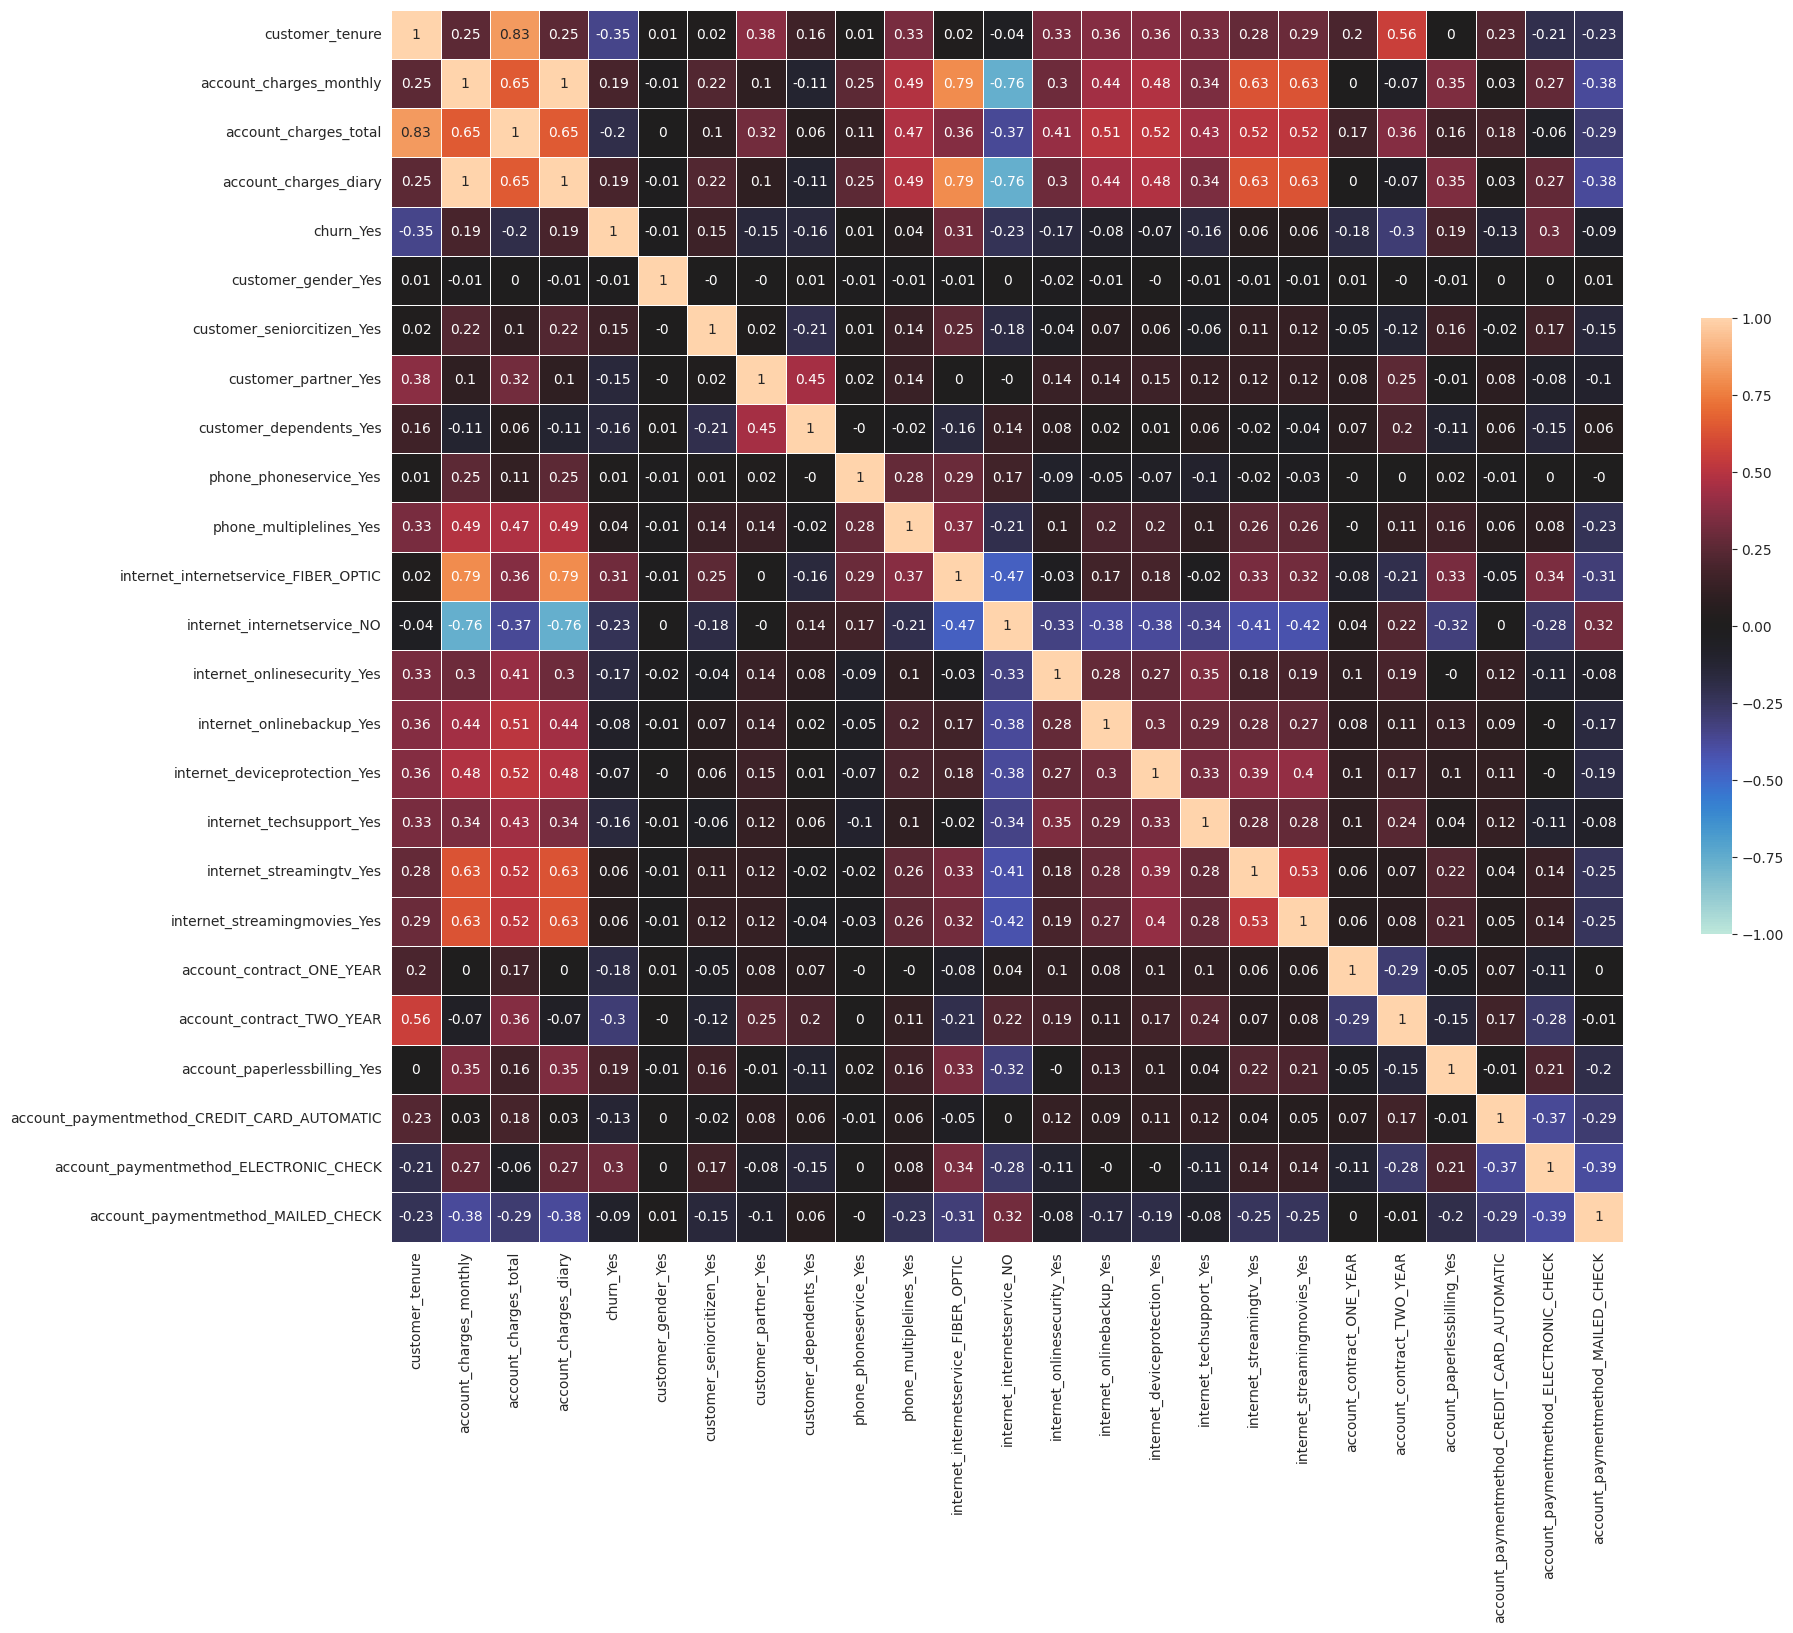

In [74]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(correlacion, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

### Correlación con las variables relevantes.

In [75]:
# Variable objetivo.
target_var = 'churn_Yes'

In [76]:
# Umbral minimo de correlación absoluta para la selecció.
limit = 0.2

In [77]:
# Filtración de varibles
variables_relevantes = correlacion.index[abs(correlacion[target_var]) >= limit].tolist()
variables_relevantes

['customer_tenure',
 'churn_Yes',
 'internet_internetservice_FIBER_OPTIC',
 'internet_internetservice_NO',
 'account_contract_TWO_YEAR',
 'account_paymentmethod_ELECTRONIC_CHECK']

In [78]:
# Introducir la variable objetivo en caso de no encontrarse
if target_var not in variables_relevantes:
    variables_relevantes.append(target_var)

variables_relevantes

['customer_tenure',
 'churn_Yes',
 'internet_internetservice_FIBER_OPTIC',
 'internet_internetservice_NO',
 'account_contract_TWO_YEAR',
 'account_paymentmethod_ELECTRONIC_CHECK']

In [79]:
# Matriz de correlacion con varibles relevantes.
corr_filtrada = correlacion.loc[variables_relevantes, variables_relevantes]
corr_filtrada

,customer_tenure,churn_Yes,internet_internetservice_FIBER_OPTIC,internet_internetservice_NO,account_contract_TWO_YEAR,account_paymentmethod_ELECTRONIC_CHECK
customer_tenure,1.000000,-0.354049,0.017930,-0.037529,0.563801,-0.210197
churn_Yes,-0.354049,1.000000,0.307463,-0.227578,-0.301552,0.301455
internet_internetservice_FIBER_OPTIC,0.017930,0.307463,1.000000,-0.465736,-0.209965,0.335763
internet_internetservice_NO,-0.037529,-0.227578,-0.465736,1.000000,0.217542,-0.284608
account_contract_TWO_YEAR,0.563801,-0.301552,-0.209965,0.217542,1.000000,-0.281147
account_paymentmethod_ELECTRONIC_CHECK,-0.210197,0.301455,0.335763,-0.284608,-0.281147,1.000000


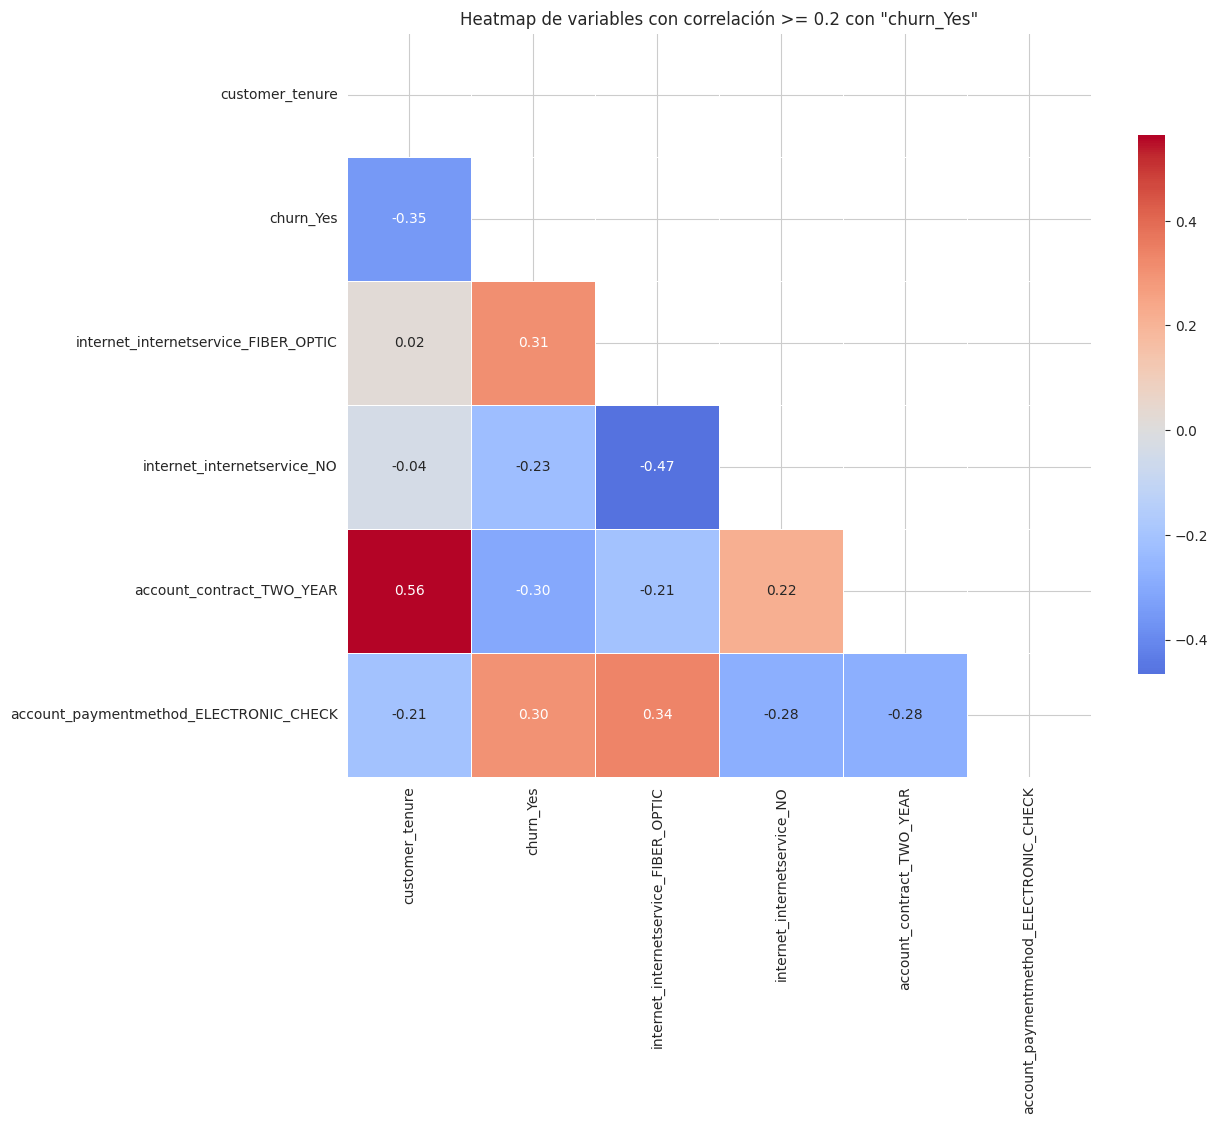

In [80]:
# Máscara para ocultar el triángulo superior de la matriz
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Grafica de la matriz
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara
)
plt.title(f'Heatmap de variables con correlación >= {limit} con "{target_var}"')
plt.show()

### Análisis dirigido.

In [93]:
ax = px.box(datos_encod, y='churn_Yes', x='account_charges_total', color='churn_Yes',
            title='Gasto total × Cancelación', color_discrete_map={ False : 'red', True : 'blue' })
ax.update_layout(title={'x':0.5, 'y':0.9, 'font':{'size': 20, 'family': 'sans-serif'}}, width= 900, height=500)
ax.update_yaxes(tickvals=[0, 1],ticktext=['No', 'Yes'])
ax.update_xaxes(title_text='GASTO TOTAL')

ax.show()

## Analisis Multicolinealidad

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [108]:
# Aquí, no incluyas la variable objetivo (ej: Churn\_Yes) en el cálculo del VIF.
X = datos_encod.drop(columns=['churn_Yes'])

In [109]:
X_const = add_constant(X)

In [117]:
# Conversion del tipo de columnas
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



,Feature,VIF
2,account_charges_monthly,inf
4,account_charges_diary,inf
11,internet_internetservice_FIBER_OPTIC,148.510456
12,internet_internetservice_NO,104.222375
0,const,73.811434
9,phone_phoneservice_Yes,34.895470
18,internet_streamingmovies_Yes,24.156974
17,internet_streamingtv_Yes,24.081396
3,account_charges_total,10.811976
1,customer_tenure,7.584594


**Resumen general del análisis VIF**

| Rango de VIF       | Interpretación                |
| ------------------ | ----------------------------- |
| VIF ≈ 1            | Sin multicolinealidad         |
| 1 < VIF < 5        | Baja (aceptable)              |
| 5 ≤ VIF < 10       | Moderada (vigilar)            |
| VIF ≥ 10           | Alta (¡atención!)             |
| VIF = ∞ (infinito) | Multicolinealidad perfecta ⚠️ |


In [129]:
### VIF baja
columnas_vif_moderada = vif_data[( vif_data['VIF'] < 5)]['Feature'].tolist()
columnas_vif_moderada

['customer_gender_Yes',
 'customer_seniorcitizen_Yes',
 'customer_partner_Yes',
 'customer_dependents_Yes',
 'account_contract_ONE_YEAR',
 'account_contract_TWO_YEAR',
 'account_paperlessbilling_Yes',
 'account_paymentmethod_CREDIT_CARD_AUTOMATIC',
 'account_paymentmethod_ELECTRONIC_CHECK',
 'account_paymentmethod_MAILED_CHECK']

In [128]:
### VIF moderada
columnas_vif_moderada = vif_data[( vif_data['VIF'] >= 5)]['Feature'].tolist()
columnas_vif_moderada

['const',
 'customer_tenure',
 'account_charges_monthly',
 'account_charges_total',
 'account_charges_diary',
 'phone_phoneservice_Yes',
 'phone_multiplelines_Yes',
 'internet_internetservice_FIBER_OPTIC',
 'internet_internetservice_NO',
 'internet_onlinesecurity_Yes',
 'internet_onlinebackup_Yes',
 'internet_deviceprotection_Yes',
 'internet_techsupport_Yes',
 'internet_streamingtv_Yes',
 'internet_streamingmovies_Yes']

In [123]:
# VIF alta
columnas_vif_alta = vif_data[vif_data['VIF'] >= 10]['Feature'].tolist()
columnas_vif_alta

['const',
 'account_charges_monthly',
 'account_charges_total',
 'account_charges_diary',
 'phone_phoneservice_Yes',
 'internet_internetservice_FIBER_OPTIC',
 'internet_internetservice_NO',
 'internet_streamingtv_Yes',
 'internet_streamingmovies_Yes']

In [ ]:
datos_encod.columns

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary', 'churn_1', 'customer_gender_1',
       'customer_seniorcitizen_1', 'customer_partner_1',
       'customer_dependents_1', 'phone_phoneservice_1',
       'phone_multiplelines_1', 'internet_internetservice_Fiber optic',
       'internet_internetservice_No', 'internet_onlinesecurity_1',
       'internet_onlinebackup_1', 'internet_deviceprotection_1',
       'internet_techsupport_1', 'internet_streamingtv_1',
       'internet_streamingmovies_1', 'account_contract_One year',
       'account_contract_Two year', 'account_paperlessbilling_1',
       'account_paymentmethod_Credit card (automatic)',
       'account_paymentmethod_Electronic check',
       'account_paymentmethod_Mailed check'],
      dtype='object')

In [111]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [142]:
X_filtro = X_const.copy()
X_filtro.columns

Index(['const', 'customer_tenure', 'account_charges_monthly',
       'account_charges_total', 'account_charges_diary', 'customer_gender_Yes',
       'customer_seniorcitizen_Yes', 'customer_partner_Yes',
       'customer_dependents_Yes', 'phone_phoneservice_Yes',
       'phone_multiplelines_Yes', 'internet_internetservice_FIBER_OPTIC',
       'internet_internetservice_NO', 'internet_onlinesecurity_Yes',
       'internet_onlinebackup_Yes', 'internet_deviceprotection_Yes',
       'internet_techsupport_Yes', 'internet_streamingtv_Yes',
       'internet_streamingmovies_Yes', 'account_contract_ONE_YEAR',
       'account_contract_TWO_YEAR', 'account_paperlessbilling_Yes',
       'account_paymentmethod_CREDIT_CARD_AUTOMATIC',
       'account_paymentmethod_ELECTRONIC_CHECK',
       'account_paymentmethod_MAILED_CHECK'],
      dtype='object')

In [143]:
# Eliminación de redundancias de las variables categoricas.
X_filtro = X_filtro.drop(columns=['account_charges_diary'], inplace=True)

AttributeError: 'NoneType' object has no attribute 'head'

In [146]:
# Eliminación de redundancias de las variables númericas.
X_filtro = X_filtro.drop(columns=["internet_internetservice_NO"], inplace=True)

AttributeError: 'NoneType' object has no attribute 'drop'

In [147]:
#
X_filtro = X_filtro.astype(float)

#
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtro.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtro.values, i) for i in range(X_filtro.shape[1])]

#
display(vif_data.sort_values(by="VIF", ascending=False))

AttributeError: 'NoneType' object has no attribute 'astype'

### VIF2

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === Eliminar la variable account.Charges.Total ===
X_final = X_filtered.drop(columns=["account_charges_total"])

# === Recalcular el VIF ===
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

# === Mostrar los resultados ordenados ===
display(vif_data_final.sort_values(by="VIF", ascending=False))

,feature,VIF
2,account_charges_monthly,22.336364
0,const,21.862879
9,internet_internetservice_Fiber optic,7.553029
1,customer_tenure,2.826562
17,account_contract_Two year,2.630079
15,internet_streamingmovies_1,2.417444
14,internet_streamingtv_1,2.399620
20,account_paymentmethod_Electronic check,1.973257
13,internet_techsupport_1,1.848965
21,account_paymentmethod_Mailed check,1.837626


## Modelo Predictivos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:
X = datos_encod.drop(columns=['churn_1'])
y = datos_encod['churn_1']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

### Regresión logistica



In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Regresión Logística")
print("Exactitud:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Regresión Logística
Exactitud: 0.7502369668246446
ROC AUC: 0.8455722684636976
Matriz de Confusión:
 [[1129  420]
 [ 107  454]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1549
        True       0.52      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110



### Random Forest

In [ ]:
# Instanciar y entrenar
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Random Forest")
print("Exactitud:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Exactitud: 0.7767772511848341
ROC AUC: 0.8212077483144207
Matriz de Confusión:
 [[1305  244]
 [ 227  334]]
              precision    recall  f1-score   support

       False       0.85      0.84      0.85      1549
        True       0.58      0.60      0.59       561

    accuracy                           0.78      2110
   macro avg       0.71      0.72      0.72      2110
weighted avg       0.78      0.78      0.78      2110

